In [2]:
import Pkg; Pkg.activate("../../")
using Distributions
using Turing
using PyPlot
import LinearAlgebra
import Random
using StatsFuns
using Flux

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`
┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260
┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1260
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260


In [37]:
eye(n::Int) = Matrix{Float64}(LinearAlgebra.I, n, n)

# Model specification.
@model MultivariateGMM(Y, K, ::Type{T}=Vector{Matrix{Float64}}) where T = begin
  N, D = size(Y)

  # Priors.
  w ~ Dirichlet(K, 1 / K)
  mu ~ filldist(Normal(0, 1), D, K)
  Sigma = T(undef, K)
  for k in 1:K
    Sigma[k] ~ InverseWishart(D + 2, eye(D))
  end

  # Likelihood.
  for i in 1:N
    Y[i, :] ~ MixtureModel([MvNormal(mu[:, k], Sigma[k]) for k in 1:K], w)
  end
end;

In [43]:
# Genreate data.
Random.seed!(0)
Y = [rand(MvNormal([-3, -3], [[1., 0.8] [0.8, 1.]]), 50)';
     rand(MvNormal([3, 3], [[1., -0.7] [-0.7, 1.]]), 30)'];
N, D = size(Y)

(80, 2)

In [39]:
# Fit model.
K = 5
m = MultivariateGMM(Y, K)
nburn, nsamps = 200, 200
@time chain = sample(m, NUTS(nburn, 0.8, max_depth=5), nburn + nsamps);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/arthur/.julia/packages/Turing/NZ9IU/src/inference/hmc.jl:629
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:01


 69.822110 seconds (463.57 M allocations: 56.920 GiB, 18.05% gc time)


In [44]:
# Collect posterior samples.
mu = reshape(group(chain, :mu).value.data[:, :, 1], nsamps, K, D);
Sigma = reshape(group(chain, :Sigma).value.data, nsamps, D, D, K);
w = group(chain, :w).value.data[:, :, 1];

In [45]:
# Posterior predictive.
postpreds = let
  _postpreds = [let
     mm = MixtureModel([MvNormal(mu[i, k, :], Sigma[i, :, :, k]) for k in 1:K],
                       w[i, :])
     rand(mm)
   end for i in 1:nsamps]
  hcat(_postpreds...);
end;

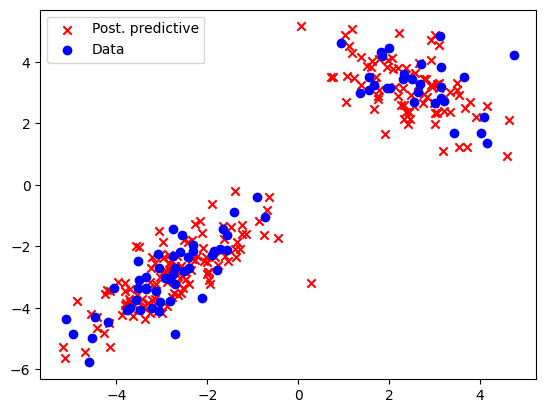

In [61]:
# Plot posterior predictive.
plt.scatter(postpreds[1, :], postpreds[2, :], label="Post. predictive", color="red", marker="x")
plt.scatter(Y[:, 1], Y[:, 2], c="blue", label="Data")
plt.legend();

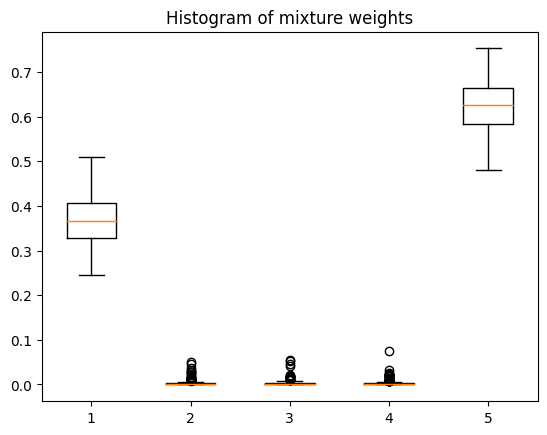

In [10]:
# Plot mixture weights (w).
plt.boxplot(w);
plt.title("Histogram of mixture weights");

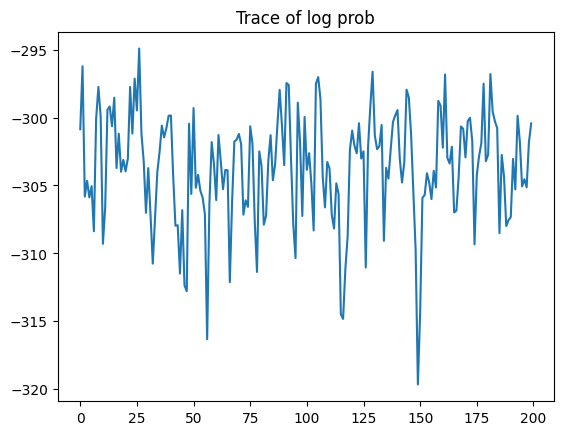

In [11]:
# Plot log unnormalized joint density.
plt.plot(get(chain, :log_density)[1].data[:, 1])
plt.title("Trace of log prob");

In [20]:
# Predict cluster membership at new location.
function predict(x::AbstractVector, mu, Sigma, w)
  K = length(w)
  ll = [logpdf(MvNormal(mu[k, :], Sigma[:, :, k]), x) for k in 1:K]
  logp = ll + log.(w)
  return exp.(logp .- logsumexp(logp))
end

function postpredict(x::AbstractVector, mus, Sigmas, ws)
  nsamps, K = size(ws)
  return [let 
     p = predict(x, mus[i, :, :], Sigmas[i, :, :, :], ws[i, :, :])
     wsample(1:K, vec(p))
   end for i in 1:nsamps]
end;

In [21]:
# Some stuff for plotting...

# TODO: Clean this up.

_xgrid = [[i, j] for i in range(-6,6,length=50), j in range(-6,6,length=50)]
xgrid = vec(_xgrid)
@time pp = hcat([postpredict(x, mu, Sigma, w) for x in xgrid]...);
pp_onehot = [Flux.onehot(pp[i, j], 1:5) for i in 1:size(pp,1), j in 1:size(pp,2)]
meanprobs_onehot = [mean(pp_onehot[:, j]) for j in 1:size(pp_onehot,2)]
stdprobs_onehot = [std(pp_onehot[:, j]) for j in 1:size(pp_onehot,2)]

xg = hcat(xgrid...)
colors = ["blue", "yellow", "orange", "green", "red"]
label = colors[argmax.(meanprobs_onehot)]
alpha = maximum.(meanprobs_onehot)

# Grids and colors.
gs = [[g[i] for g in _xgrid] for i in 1:2]
Colors = ["Blues", "YlOrBr", "Oranges", "Greens", "Reds"];

  3.103775 seconds (38.80 M allocations: 2.488 GiB, 23.66% gc time)


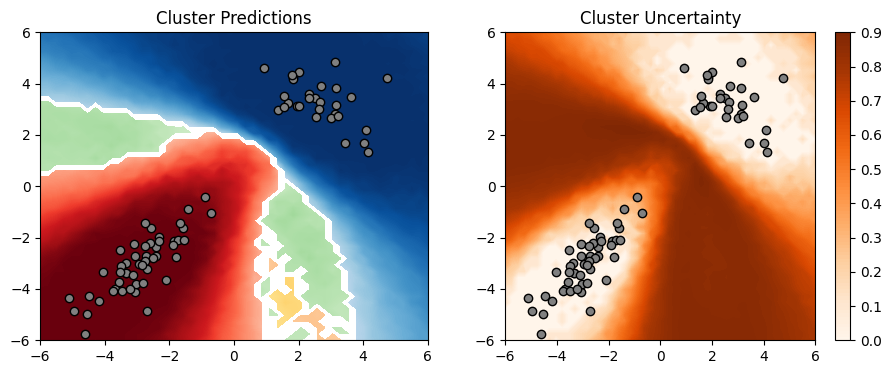

In [62]:
plt.figure(figsize=(11, 4))

# Cluster predictions.
plt.subplot(1, 2, 1)
for k in 1:K
  idx = findall(label .!== colors[k])
  _alpha = copy(reshape(alpha, size(gs[1])))
  _alpha[idx] .= NaN  # don't plot for regions that don't belong to cluster k.
  plt.contourf(gs[1], gs[2], _alpha, 101, cmap=Colors[k], vmin=0, vmax=1)
end
plt.title("Cluster Predictions")
plt.scatter(Y[:, 1], Y[:, 2], color="grey", edgecolor="black");

# Cluster uncertainty.
plt.subplot(1, 2, 2)
uq = [sqrt(sum(s.^2)) for s in stdprobs_onehot]
uq = reshape(uq, size(gs[1]))
plt.contourf(gs[1], gs[2], uq, 101, cmap="Oranges", vmin=0)
plt.colorbar()
plt.title("Cluster Uncertainty")
plt.scatter(Y[:, 1], Y[:, 2], color="grey", edgecolor="black");

The left figure shows the predicted cluster by region. The mixture model was fit with 5 components. So 5 colors are shown. (Red, green, yellow, orange, and blue.) The intensity of the colors relates to the confidence of the predictions. i.e. Darker reds $\Rightarrow$ higher probability the region is in cluster "red". More specifically, for each region, first, I ask, "what cluster does this region most likely belong to?" (answered by popular vote). Then I use color intensities to represent the degree of confidence.

The right figure shows the uncertainty at each region. White means less uncertainty, dark orange means more uncertainty. At regions with more data, the uncertainty is lower. At regions with less/no data, uncertainty is naturally higher.